## Unsupervised Machine Learning with K-means Clustering

### The notebook will be broken down into a few steps:

1) Loading and exploring the data

2) Exploratory Data Analysis (w. Visualization)

3) Training a K-means Clustering model

4) Implementing the Elbow Method for finding k-value 

5) Predict test dataset's values

In [1]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Step 1: Loading and exploring the data

In [3]:
my_ds = pd.read_csv("https://raw.githubusercontent.com/krishnaik06/DBSCAN-Algorithm/master/Mall_Customers.csv")
my_ds.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


As we can see from the table below, our dataset has 5 columns: CustomerID, Genre, Age, Annual Income (in thousands of dollars), and Spending score (1-100). Higher spending score means higher spending in the past.

In [4]:
my_ds.shape

(200, 5)

There are about 200 records (rows) in our dataset with 5 columns.

### Step 2: EDA

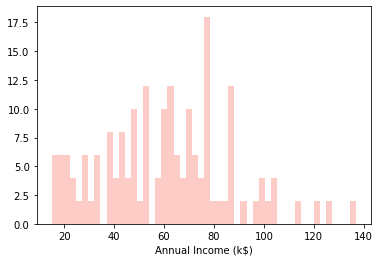

In [11]:
# using seaborn to plot a histogram for Annual Income variable. 
sns.distplot(my_ds["Annual Income (k$)"], kde=False, bins=50, color="salmon")

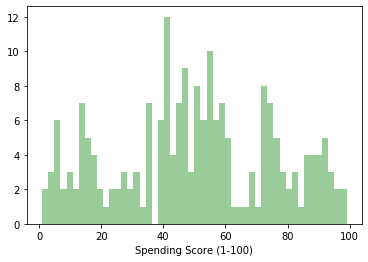

In [12]:
sns.distplot(my_ds["Spending Score (1-100)"], kde=False, bins=50, color="green")

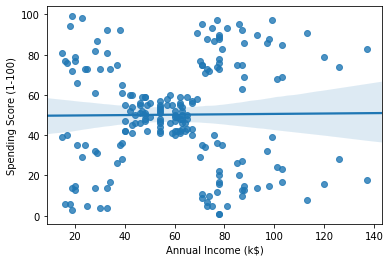

In [16]:
sns.regplot(x=my_ds["Annual Income (k$)"], y="Spending Score (1-100)", data=my_ds)

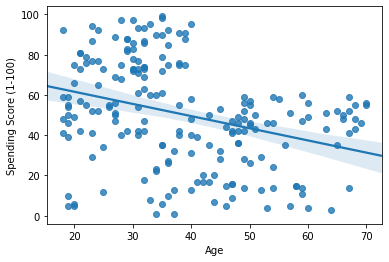

In [17]:
sns.regplot(x=my_ds["Age"], y="Spending Score (1-100)", data=my_ds)

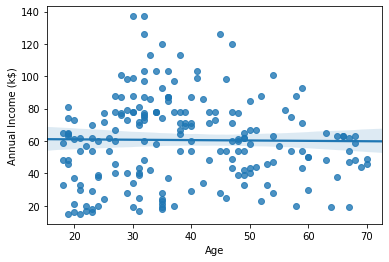

In [18]:
sns.regplot(x=my_ds["Age"], y="Annual Income (k$)", data=my_ds)

### Step 3: Training a K-means Clustering model

In [20]:
my_ds = my_ds.filter(["Annual Income (k$)", "Spending Score (1-100)"], axis=1)
my_ds.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [21]:
# train our model with K-means Clustering
km_model = KMeans(n_clusters=4)
km_model.fit(my_ds)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [22]:
print(km_model.cluster_centers_)

[[48.26       56.48      ]
 [86.53846154 82.12820513]
 [87.         18.63157895]
 [26.30434783 20.91304348]]


In [23]:
# predicted label values
print(km_model.labels_)

[3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3
 0 3 0 3 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]


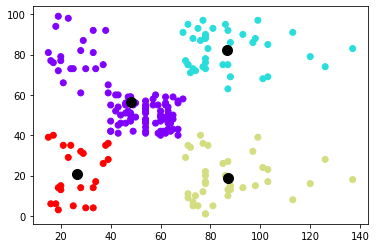

In [26]:
#print the datapoints (in 4 different colors)
plt.scatter(my_ds.values[:,0], my_ds.values[:,1], c=km_model.labels_, cmap='rainbow')

# print the centroids (in black)
plt.scatter(km_model.cluster_centers_[:,0], km_model.cluster_centers_[:,1], s=100, c="black")

### Step 4: Implementing the Elbow Method for finding k-value

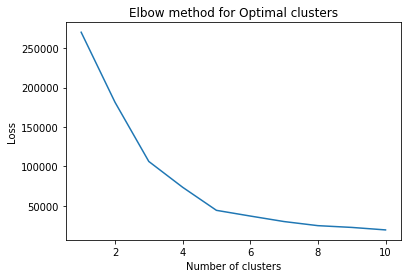

In [27]:
# training KMeans on K values from 1 to 10
loss = []
for i in range(1,11):
    km = KMeans(n_clusters=i).fit(my_ds)
    loss.append(km.inertia_)
    
#printing loss against number of clusters
plt.plot(range(1,11), loss)
plt.title("Elbow method for Optimal clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Loss")
plt.show()

In [28]:
# Let's try segmenting our customers into 5 groups instead of 4

km_model = KMeans(n_clusters=5)
km_model.fit(my_ds)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

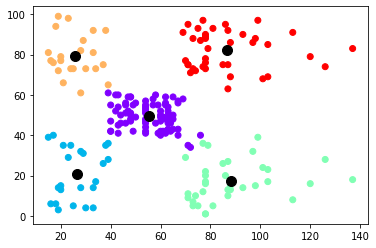

In [29]:
#print the datapoints (in 4 different colors)
plt.scatter(my_ds.values[:,0], my_ds.values[:,1], c=km_model.labels_, cmap='rainbow')

# print the centroids (in black)
plt.scatter(km_model.cluster_centers_[:,0], km_model.cluster_centers_[:,1], s=100, c="black")

### Step 5: Predict values

In [31]:
# create a dataframe containing index values of all the records in the dataset and their corresponding cluster labels

cluster_map = pd.DataFrame()
cluster_map['data_index'] = my_ds.index.values
cluster_map["cluster"] = km_model.labels_
cluster_map

,data_index,cluster
0,0,1
1,1,3
2,2,1
3,3,3
4,4,1
5,5,3
6,6,1
7,7,3
8,8,1
9,9,3


In [33]:
# Let's see the records belong to cluster 1

cluster_map_1 = cluster_map[cluster_map.cluster==1]
cluster_map_1

,data_index,cluster
0,0,1
2,2,1
4,4,1
6,6,1
8,8,1
10,10,1
12,12,1
14,14,1
16,16,1
18,18,1
